# Experimenting with Movie Lens 100k

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import sys
sys.path.append('../Library')

from Metrics.RMSE import RMSE
from Modules.DynamicDF import DynamicDF as DictionaryFilter
from Modules.NMF import NMF
from Modules.PMF import PMF
from Modules.BPMF import BPMF
from Modules.MVGMF import MVGMF
from Modules.SGDMF import SGDMF

from sklearn.model_selection import train_test_split
import tensorflow as tf

import time
from tqdm import tqdm

In [ ]:
# Read the dataset
dataset = pd.read_csv('../Data/MovieLens/Small/dataset.csv')

# Display the dataset
dataset.head()

In [ ]:
# Plot the distribution of ratings
plt.figure(figsize=(3, 4))
rating_counts = dataset['Rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.xticks(rating_counts.index, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('MovieLens 100K', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

In [ ]:
# Split the train and validation data
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

In [ ]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1
NUM_FACTORS = [1, 2, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256]

In [ ]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

## NMF

In [ ]:
def fit_nmf(num_movies, num_users, num_factors, init_scale, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a NMF model to the data and returns the training and testing RMSEs.
    """
    # Initialize variables
    nmf_train_RMSE = []
    nmf_test_RMSE = []
    best_epoch = 0
    best_pred = None

    # Create the model
    nmf = NMF(m = num_movies, n = num_users, num_factors=num_factors, init_scale=init_scale)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        nmf(train_tensor, train_mask)
        pred = tf.matmul(nmf.C, nmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        nmf_train_RMSE.append(train_RMSE.result().numpy())
        nmf_test_RMSE.append(test_RMSE.result().numpy())

        if test_RMSE.result().numpy() < nmf_test_RMSE[best_epoch]:
            best_epoch = epoch
            best_pred = pred

        train_RMSE.reset_states()
        test_RMSE.reset_states()
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return nmf_train_RMSE, nmf_test_RMSE, time_taken, best_epoch, best_pred

In [ ]:
NUM_EPOCHS = 10000

# Validate the algorithm
nmf_train_RMSE, nmf_test_RMSE, time_taken, best_epoch, best_pred = fit_nmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(nmf_train_RMSE, label='Train RMSE')
plt.plot(nmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

In [ ]:
# Print the best epoch
print(f'Best epoch: {best_epoch}')

# Get predictions corresponding to the test sparse positions
best_pred = tf.gather_nd(best_pred, test_sparse_tensor.indices)

# Round the predictions to the nearest integer between 1 and 5
best_pred = tf.clip_by_value(tf.round(best_pred), 1, 5)

# Plot the heatmap of counts of actual vs predicted ratings
sns.heatmap(pd.crosstab(test_sparse_tensor.values, best_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('Actual vs predicted ratings')
plt.show()

In [ ]:
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []

for num_factors in tqdm(NUM_FACTORS):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_nmf(NUM_MOVIES, NUM_USERS, num_factors, dataset['Rating'].mean() / num_factors, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])

# Write to csv
results = pd.DataFrame(data={
    'num_factors': NUM_FACTORS,
    'time_taken': time_takens,
    'best_epoch': best_epochs,
    'train_RMSE': train_RMSEs,
    'test_RMSE': test_RMSEs
})
results.to_csv('Results/ML100K/NMF/num_factors.csv', index=False)

# Get the best hyperparameters
BEST_NUM_FACTORS = NUM_FACTORS[np.argmin(test_RMSEs)]
print(f'Best number of factors: {BEST_NUM_FACTORS}')

In [ ]:
# Define the number of runs
NUM_RUNS = 100

# Initialize lists to store results
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []
predictions = None

# Run the algorithm for the specified number of runs
for _ in tqdm(range(NUM_RUNS)):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_nmf(NUM_MOVIES, NUM_USERS, BEST_NUM_FACTORS, dataset['Rating'].mean() / BEST_NUM_FACTORS, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)
    
    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])
    if predictions == None:
        predictions = best_pred
    elif best_pred != None:
        predictions += best_pred

# Create a dataframe to store the results
results = pd.DataFrame(data={
    'Run': np.arange(1, NUM_RUNS+1),
    'Time Taken': time_takens,
    'Best Epoch': best_epochs,
    'Train RMSE': train_RMSEs,
    'Test RMSE': test_RMSEs
})

# Save the results to a CSV file
results.to_csv('Results/ML100K/NMF/Results.csv', index=False)

# Save the average predictions to a CSV file
average_predictions = predictions / NUM_RUNS
average_predictions = tf.gather_nd(average_predictions, test_sparse_tensor.indices)
average_predictions = tf.clip_by_value(tf.round(average_predictions), 1, 5)
average_predictions = average_predictions.numpy().astype(int)
predictions_df = pd.DataFrame(data={
    'x': test_sparse_tensor.indices[:, 0],
    'y': test_sparse_tensor.indices[:, 1],
    'Actual': test_sparse_tensor.values.numpy(),
    'Predicted': average_predictions
})
predictions_df.to_csv('Results/ML100K/NMF/Predictions.csv', index=False)

## PMF

In [ ]:
def fit_pmf(num_movies, num_users, num_factors, init_scale, lambda_C, lambda_X, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a PMF model to the data and returns the training and testing RMSEs.
    """
    
    # Initialize variables
    pmf_train_RMSE = []
    pmf_test_RMSE = []
    best_epoch = 0
    best_pred = None

    # Create the model
    pmf = PMF(m = num_movies, n = num_users, num_factors=num_factors, init_scale=init_scale, lambda_C=lambda_C, lambda_X=lambda_X)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        pmf(train_tensor)
        pred = tf.matmul(pmf.C, pmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        pmf_train_RMSE.append(train_RMSE.result().numpy())
        pmf_test_RMSE.append(test_RMSE.result().numpy())

        if test_RMSE.result().numpy() < pmf_test_RMSE[best_epoch]:
            best_epoch = epoch
            best_pred = pred

        train_RMSE.reset_states()
        test_RMSE.reset_states()
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return pmf_train_RMSE, pmf_test_RMSE, time_taken, best_epoch, best_pred

In [ ]:
NUM_EPOCHS = 600
LAMBDA_C = 0.01
LAMBDA_X = 0.01

# Validate the algorithm
pmf_train_RMSE, pmf_test_RMSE, time_taken, best_epoch, best_pred = fit_pmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, LAMBDA_C, LAMBDA_X, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(pmf_train_RMSE, label='Train RMSE')
plt.plot(pmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

In [ ]:
# Print the best epoch
print(f'Best epoch: {best_epoch}')

# Get predictions corresponding to the test sparse positions
best_pred = tf.gather_nd(best_pred, test_sparse_tensor.indices)

# Round the predictions to the nearest integer between 1 and 5
best_pred = tf.clip_by_value(tf.round(best_pred), 1, 5)

# Plot the heatmap of counts of actual vs predicted ratings
sns.heatmap(pd.crosstab(test_sparse_tensor.values, best_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('Actual vs predicted ratings')
plt.show()

In [ ]:
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []

for num_factors in tqdm(NUM_FACTORS):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_pmf(NUM_MOVIES, NUM_USERS, num_factors, dataset['Rating'].mean() / num_factors, LAMBDA_C, LAMBDA_X, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])

# Write to csv
results = pd.DataFrame(data={
    'num_factors': NUM_FACTORS,
    'time_taken': time_takens,
    'best_epoch': best_epochs,
    'train_RMSE': train_RMSEs,
    'test_RMSE': test_RMSEs
})
results.to_csv('Results/ML100K/PMF/num_factors.csv', index=False)

# Get the best hyperparameters
BEST_NUM_FACTORS = NUM_FACTORS[np.argmin(test_RMSEs)]
print(f'Best number of factors: {BEST_NUM_FACTORS}')

In [ ]:
# Define the number of runs
NUM_RUNS = 100

# Initialize lists to store results
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []
predictions = None

# Run the algorithm for the specified number of runs
for _ in tqdm(range(NUM_RUNS)):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_pmf(NUM_MOVIES, NUM_USERS, BEST_NUM_FACTORS, dataset['Rating'].mean() / BEST_NUM_FACTORS, LAMBDA_C, LAMBDA_X, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)
    
    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])
    if predictions == None:
        predictions = best_pred
    elif best_pred != None:
        predictions += best_pred

# Create a dataframe to store the results
results = pd.DataFrame(data={
    'Run': np.arange(1, NUM_RUNS+1),
    'Time Taken': time_takens,
    'Best Epoch': best_epochs,
    'Train RMSE': train_RMSEs,
    'Test RMSE': test_RMSEs
})

# Save the results to a CSV file
results.to_csv('Results/ML100K/PMF/Results.csv', index=False)

# Save the average predictions to a CSV file
average_predictions = predictions / NUM_RUNS
average_predictions = tf.gather_nd(average_predictions, test_sparse_tensor.indices)
average_predictions = tf.clip_by_value(tf.round(average_predictions), 1, 5)
average_predictions = average_predictions.numpy().astype(int)
predictions_df = pd.DataFrame(data={
    'x': test_sparse_tensor.indices[:, 0],
    'y': test_sparse_tensor.indices[:, 1],
    'Actual': test_sparse_tensor.values.numpy(),
    'Predicted': average_predictions
})
predictions_df.to_csv('Results/ML100K/PMF/Predictions.csv', index=False)

## BPMF

In [ ]:
def fit_bpmf(num_movies, num_users, num_factors, init_scale, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a BPMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    bpmf_train_RMSE = []
    bpmf_test_RMSE = []
    best_epoch = 0
    best_pred = None

    # Create the model
    bpmf = BPMF(m = num_movies, n = num_users, num_factors=num_factors, init_scale=init_scale)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        bpmf(train_tensor)
        pred = tf.matmul(bpmf.C, bpmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        bpmf_train_RMSE.append(train_RMSE.result().numpy())
        bpmf_test_RMSE.append(test_RMSE.result().numpy())

        if test_RMSE.result().numpy() < bpmf_test_RMSE[best_epoch]:
            best_epoch = epoch
            best_pred = pred

        train_RMSE.reset_states()
        test_RMSE.reset_states()
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return bpmf_train_RMSE, bpmf_test_RMSE, time_taken, best_epoch, best_pred

In [ ]:
NUM_EPOCHS = 8

# Validate the algorithm
bpmf_train_RMSE, bpmf_test_RMSE, time_taken, best_epoch, best_pred = fit_bpmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(bpmf_train_RMSE, label='Train RMSE')
plt.plot(bpmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

In [ ]:
# Print the best epoch
print(f'Best epoch: {best_epoch}')

# Get predictions corresponding to the test sparse positions
best_pred = tf.gather_nd(best_pred, test_sparse_tensor.indices)

# Round the predictions to the nearest integer between 1 and 5
best_pred = tf.clip_by_value(tf.round(best_pred), 1, 5)

# Plot the heatmap of counts of actual vs predicted ratings
sns.heatmap(pd.crosstab(test_sparse_tensor.values, best_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('Actual vs predicted ratings')
plt.show()

In [ ]:
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []

for num_factors in tqdm(NUM_FACTORS):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_bpmf(NUM_MOVIES, NUM_USERS, num_factors, dataset['Rating'].mean() / num_factors, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])

# Write to csv
results = pd.DataFrame(data={
    'num_factors': NUM_FACTORS,
    'time_taken': time_takens,
    'best_epoch': best_epochs,
    'train_RMSE': train_RMSEs,
    'test_RMSE': test_RMSEs
})
results.to_csv('Results/ML100K/BPMF/num_factors.csv', index=False)

# Get the best hyperparameters
BEST_NUM_FACTORS = NUM_FACTORS[np.argmin(test_RMSEs)]
print(f'Best number of factors: {BEST_NUM_FACTORS}')

In [ ]:
# Define the number of runs
NUM_RUNS = 100

# Initialize lists to store results
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []
predictions = None

# Run the algorithm for the specified number of runs
for _ in tqdm(range(NUM_RUNS)):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_bpmf(NUM_MOVIES, NUM_USERS, BEST_NUM_FACTORS, dataset['Rating'].mean() / BEST_NUM_FACTORS, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)
    
    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])
    if predictions == None:
        predictions = best_pred
    elif best_pred != None:
        predictions += best_pred

# Create a dataframe to store the results
results = pd.DataFrame(data={
    'Run': np.arange(1, NUM_RUNS+1),
    'Time Taken': time_takens,
    'Best Epoch': best_epochs,
    'Train RMSE': train_RMSEs,
    'Test RMSE': test_RMSEs
})

# Save the results to a CSV file
results.to_csv('Results/ML100K/BPMF/Results.csv', index=False)

# Save the average predictions to a CSV file
average_predictions = predictions / NUM_RUNS
average_predictions = tf.gather_nd(average_predictions, test_sparse_tensor.indices)
average_predictions = tf.clip_by_value(tf.round(average_predictions), 1, 5)
average_predictions = average_predictions.numpy().astype(int)
np.savetxt('Results/ML100K/BPMF/Predictions.csv', average_predictions, delimiter=',', fmt='%d')
predictions_df = pd.DataFrame(data={
    'x': test_sparse_tensor.indices[:, 0],
    'y': test_sparse_tensor.indices[:, 1],
    'Actual': test_sparse_tensor.values.numpy(),
    'Predicted': average_predictions
})
predictions_df.to_csv('Results/ML100K/BPMF/Predictions.csv', index=False)

## MVGMF

In [ ]:
def fit_mvgmf(num_movies, num_users, num_factors, init_scale, k, sigma, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a MVGMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    mvgmf_train_RMSE = []
    mvgmf_test_RMSE = []
    best_epoch = 0
    best_pred = None

    # Create the model
    mvgmf = MVGMF(m = num_movies, n = num_users, num_factors=4, k=k, sigma=sigma, init_scale=init_scale)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        mvgmf(train_tensor, train_mask)
        pred = tf.matmul(mvgmf.C, mvgmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        mvgmf_train_RMSE.append(train_RMSE.result().numpy())
        mvgmf_test_RMSE.append(test_RMSE.result().numpy())

        if test_RMSE.result().numpy() < mvgmf_test_RMSE[best_epoch]:
            best_epoch = epoch
            best_pred = pred

        train_RMSE.reset_states()
        test_RMSE.reset_states()

    end_time = time.time()
    time_taken = end_time - start_time

    return mvgmf_train_RMSE, mvgmf_test_RMSE, time_taken, best_epoch, best_pred

In [ ]:
NUM_EPOCHS = 120
K = 40
SIGMA = 0.2

# Validate the algorithm
mvgmf_train_RMSE, mvgmf_test_RMSE, time_taken, best_epoch, best_pred = fit_mvgmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, K, SIGMA, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(mvgmf_train_RMSE, label='Train RMSE')
plt.plot(mvgmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

In [ ]:
# Print the best epoch
print(f'Best epoch: {best_epoch}')

# Get predictions corresponding to the test sparse positions
best_pred = tf.gather_nd(best_pred, test_sparse_tensor.indices)

# Round the predictions to the nearest integer between 1 and 5
best_pred = tf.clip_by_value(tf.round(best_pred), 1, 5)

# Plot the heatmap of counts of actual vs predicted ratings
sns.heatmap(pd.crosstab(test_sparse_tensor.values, best_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('Actual vs predicted ratings')
plt.show()

In [ ]:
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []

for num_factors in tqdm(NUM_FACTORS):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_mvgmf(NUM_MOVIES, NUM_USERS, num_factors, dataset['Rating'].mean() / num_factors, K, SIGMA, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])

# Write to csv
results = pd.DataFrame(data={
    'num_factors': NUM_FACTORS,
    'time_taken': time_takens,
    'best_epoch': best_epochs,
    'train_RMSE': train_RMSEs,
    'test_RMSE': test_RMSEs
})
results.to_csv('Results/ML100K/MVGMF/num_factors.csv', index=False)

# Get the best hyperparameters
BEST_NUM_FACTORS = NUM_FACTORS[np.argmin(test_RMSEs)]
print(f'Best number of factors: {BEST_NUM_FACTORS}')

In [ ]:
# Define the number of runs
NUM_RUNS = 100

# Initialize lists to store results
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []
predictions = None

# Run the algorithm for the specified number of runs
for _ in tqdm(range(NUM_RUNS)):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_mvgmf(NUM_MOVIES, NUM_USERS, BEST_NUM_FACTORS, dataset['Rating'].mean() / BEST_NUM_FACTORS, K, SIGMA, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)
    
    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])
    if predictions == None:
        predictions = best_pred
    elif best_pred != None:
        predictions += best_pred

# Create a dataframe to store the results
results = pd.DataFrame(data={
    'Run': np.arange(1, NUM_RUNS+1),
    'Time Taken': time_takens,
    'Best Epoch': best_epochs,
    'Train RMSE': train_RMSEs,
    'Test RMSE': test_RMSEs
})

# Save the results to a CSV file
results.to_csv('Results/ML100K/MVGMF/Results.csv', index=False)

# Save the average predictions to a CSV file
average_predictions = predictions / NUM_RUNS
average_predictions = tf.gather_nd(average_predictions, test_sparse_tensor.indices)
average_predictions = tf.clip_by_value(tf.round(average_predictions), 1, 5)
average_predictions = average_predictions.numpy().astype(int)
predictions_df = pd.DataFrame(data={
    'x': test_sparse_tensor.indices[:, 0],
    'y': test_sparse_tensor.indices[:, 1],
    'Actual': test_sparse_tensor.values.numpy(),
    'Predicted': average_predictions
})
predictions_df.to_csv('Results/ML100K/MVGMF/Predictions.csv', index=False)

## Dictionary filter

In [ ]:
def create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, test_sparse_tensor):
    """
    Create a TF dataset from the sparse tensors.
    """
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=num_users // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=num_users // batch_size, axis=1)
        for i in range(num_users // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32),
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32)
        )
    )

    return dataset

In [ ]:
def fit_df(num_movies, num_users, num_factors, init_scale, train_lambda, batch_size, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a Dictionary Filter model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    df_train_RMSE = np.zeros(num_epochs)
    df_test_RMSE = np.zeros(num_epochs)
    best_epoch = 0
    best_pred = None

    # Create the model
    model = DictionaryFilter(num_movies, num_factors, init_scale, train_lambda)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dataset
    dataset = create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, test_sparse_tensor)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        X = []

        for train_batch, test_batch in dataset:
            x = model(train_batch)
            X.append(x)
            train_RMSE.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            test_RMSE.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))

        df_train_RMSE[epoch] = train_RMSE.result().numpy()
        df_test_RMSE[epoch] = test_RMSE.result().numpy()

        if df_test_RMSE[epoch] < df_test_RMSE[best_epoch]:
            X = tf.concat(X, axis=1)
            best_epoch = epoch
            best_pred = tf.matmul(model.C, X)

        train_RMSE.reset_states()
        test_RMSE.reset_states()

    end_time = time.time()
    time_taken = end_time - start_time

    return df_train_RMSE, df_test_RMSE, time_taken, best_epoch, best_pred

In [ ]:
NUM_EPOCHS = 30
TRAIN_LAMBDA = 2.0
BATCH_SIZE = 32

# Validate the algorithm
df_train_RMSE, df_test_RMSE, time_taken, best_epoch, best_pred = fit_df(NUM_MOVIES, NUM_USERS, 4, dataset['Rating'].mean() / 4, TRAIN_LAMBDA, BATCH_SIZE, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(df_train_RMSE, label='Train RMSE')
plt.plot(df_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

In [ ]:
# Print the best epoch
print(f'Best epoch: {best_epoch}')

# Get predictions corresponding to the test sparse positions
best_pred = tf.gather_nd(best_pred, test_sparse_tensor.indices)

# Round the predictions to the nearest integer between 1 and 5
best_pred = tf.clip_by_value(tf.round(best_pred), 1, 5)

# Plot the heatmap of counts of actual vs predicted ratings
sns.heatmap(pd.crosstab(test_sparse_tensor.values, best_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('Actual vs predicted ratings')
plt.show()

In [ ]:
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []

for num_factors in tqdm(NUM_FACTORS):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_df(NUM_MOVIES, NUM_USERS, num_factors, dataset['Rating'].mean() / num_factors, TRAIN_LAMBDA, BATCH_SIZE, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])

# Write to csv
results = pd.DataFrame(data={
    'num_factors': NUM_FACTORS,
    'time_taken': time_takens,
    'best_epoch': best_epochs,
    'train_RMSE': train_RMSEs,
    'test_RMSE': test_RMSEs
})
results.to_csv('Results/ML100K/DF/num_factors.csv', index=False)

# Get the best hyperparameters
BEST_NUM_FACTORS = NUM_FACTORS[np.argmin(test_RMSEs)]
print(f'Best number of factors: {BEST_NUM_FACTORS}')

In [ ]:
BEST_NUM_FACTORS = 4

In [ ]:
# Define the number of runs
NUM_RUNS = 100

# Initialize lists to store results
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []
predictions = None

# Run the algorithm for the specified number of runs
for _ in tqdm(range(NUM_RUNS)):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_df(NUM_MOVIES, NUM_USERS, BEST_NUM_FACTORS, dataset['Rating'].mean() / BEST_NUM_FACTORS, TRAIN_LAMBDA, BATCH_SIZE, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)
    
    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])
    if predictions == None:
        predictions = best_pred
    elif best_pred != None:
        predictions += best_pred

# Create a dataframe to store the results
results = pd.DataFrame(data={
    'Run': np.arange(1, NUM_RUNS+1),
    'Time Taken': time_takens,
    'Best Epoch': best_epochs,
    'Train RMSE': train_RMSEs,
    'Test RMSE': test_RMSEs
})

# Save the results to a CSV file
results.to_csv('Results/ML100K/DF/Results.csv', index=False)

# Save the average predictions to a CSV file
average_predictions = predictions / NUM_RUNS
average_predictions = tf.gather_nd(average_predictions, test_sparse_tensor.indices)
average_predictions = tf.clip_by_value(tf.round(average_predictions), 1, 5)
average_predictions = average_predictions.numpy().astype(int)
predictions_df = pd.DataFrame(data={
    'x': test_sparse_tensor.indices[:, 0],
    'y': test_sparse_tensor.indices[:, 1],
    'Actual': test_sparse_tensor.values.numpy(),
    'Predicted': average_predictions
})
predictions_df.to_csv('Results/ML100K/DF/Predictions.csv', index=False)

## SGDMF

In [ ]:
def fit_sgdmf(num_movies, num_users, num_factors, init_scale, alpha, beta, batch_size, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits an SGDMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    sgdmf_train_RMSE = np.zeros(num_epochs)
    sgdmf_test_RMSE = np.zeros(num_epochs)
    best_epoch = 0
    best_pred = None

    # Create the model
    model = SGDMF(num_movies, num_factors, init_scale, alpha, beta)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dataset
    dataset = create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, test_sparse_tensor)

    # Train the model
    start_time = time.time()
    k = 0
    for epoch in range(num_epochs):
        X = []

        for train_batch, test_batch in dataset:
            k += 1
            x = model(train_batch, k)
            X.append(x)
            train_RMSE.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            test_RMSE.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))

        sgdmf_train_RMSE[epoch] = train_RMSE.result().numpy()
        sgdmf_test_RMSE[epoch] = test_RMSE.result().numpy()

        if sgdmf_test_RMSE[epoch] < sgdmf_test_RMSE[best_epoch]:
            X = tf.concat(X, axis=1)
            best_epoch = epoch
            best_pred = tf.matmul(model.C, X)

        train_RMSE.reset_states()
        test_RMSE.reset_states()

    end_time = time.time()
    time_taken = end_time - start_time

    return sgdmf_train_RMSE, sgdmf_test_RMSE, time_taken, best_epoch, best_pred

In [ ]:
NUM_EPOCHS = 12
ALPHA = 0.1
BETA = 0.0
BATCH_SIZE = 32

# Validate the algorithm
sgdmf_train_RMSE, sgdmf_test_RMSE, time_taken, best_epoch, best_pred = fit_sgdmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, ALPHA, BETA, BATCH_SIZE, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(sgdmf_train_RMSE, label='Train RMSE')
plt.plot(sgdmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

In [ ]:
# Print the best epoch
print(f'Best epoch: {best_epoch}')

# Get predictions corresponding to the test sparse positions
best_pred = tf.gather_nd(best_pred, test_sparse_tensor.indices)

# Round the predictions to the nearest integer between 1 and 5
best_pred = tf.clip_by_value(tf.round(best_pred), 1, 5)

# Plot the heatmap of counts of actual vs predicted ratings
sns.heatmap(pd.crosstab(test_sparse_tensor.values, best_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('Actual vs predicted ratings')
plt.show()

In [ ]:
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []

for num_factors in tqdm(NUM_FACTORS):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_sgdmf(NUM_MOVIES, NUM_USERS, num_factors, dataset['Rating'].mean() / num_factors, ALPHA, BETA, BATCH_SIZE, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)

    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])

# Write to csv
results = pd.DataFrame(data={
    'num_factors': NUM_FACTORS,
    'time_taken': time_takens,
    'best_epoch': best_epochs,
    'train_RMSE': train_RMSEs,
    'test_RMSE': test_RMSEs
})
results.to_csv('Results/ML100K/SGDMF/num_factors.csv', index=False)

# Get the best hyperparameters
BEST_NUM_FACTORS = NUM_FACTORS[np.argmin(test_RMSEs)]
print(f'Best number of factors: {BEST_NUM_FACTORS}')

In [ ]:
# Define the number of runs
NUM_RUNS = 100

# Initialize lists to store results
time_takens = []
best_epochs = []
train_RMSEs = []
test_RMSEs = []
predictions = None

# Run the algorithm for the specified number of runs
for _ in tqdm(range(NUM_RUNS)):
    train_RMSE, test_RMSE, time_taken, best_epoch, best_pred = fit_sgdmf(NUM_MOVIES, NUM_USERS, BEST_NUM_FACTORS, dataset['Rating'].mean() / BEST_NUM_FACTORS, ALPHA, BETA, BATCH_SIZE, NUM_EPOCHS, train_sparse_tensor, test_sparse_tensor)
    
    time_takens.append(time_taken)
    best_epochs.append(best_epoch)
    train_RMSEs.append(train_RMSE[best_epoch])
    test_RMSEs.append(test_RMSE[best_epoch])
    if predictions == None:
        predictions = best_pred
    elif best_pred != None:
        predictions += best_pred

# Create a dataframe to store the results
results = pd.DataFrame(data={
    'Run': np.arange(1, NUM_RUNS+1),
    'Time Taken': time_takens,
    'Best Epoch': best_epochs,
    'Train RMSE': train_RMSEs,
    'Test RMSE': test_RMSEs
})

# Save the results to a CSV file
results.to_csv('Results/ML100K/SGDMF/Results.csv', index=False)

# Save the average predictions to a CSV file
average_predictions = predictions / NUM_RUNS
average_predictions = tf.gather_nd(average_predictions, test_sparse_tensor.indices)
average_predictions = tf.clip_by_value(tf.round(average_predictions), 1, 5)
average_predictions = average_predictions.numpy().astype(int)
predictions_df = pd.DataFrame(data={
    'x': test_sparse_tensor.indices[:, 0],
    'y': test_sparse_tensor.indices[:, 1],
    'Actual': test_sparse_tensor.values.numpy(),
    'Predicted': average_predictions
})
predictions_df.to_csv('Results/ML100K/SGDMF/Predictions.csv', index=False)

# Experimentaion results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nmf_num_factors = pd.read_csv('Results/ML100K/NMF/num_factors.csv')
nmf_results = pd.read_csv('Results/ML100K/NMF/Results.csv')
nmf_predictions = pd.read_csv('Results/ML100K/NMF/Predictions.csv')

pmf_num_factors = pd.read_csv('Results/ML100K/PMF/num_factors.csv')
pmf_results = pd.read_csv('Results/ML100K/PMF/Results.csv')
pmf_predictions = pd.read_csv('Results/ML100K/PMF/Predictions.csv')

bpmf_num_factors = pd.read_csv('Results/ML100K/BPMF/num_factors.csv')
bpmf_results = pd.read_csv('Results/ML100K/BPMF/Results.csv')
bpmf_predictions = pd.read_csv('Results/ML100K/BPMF/Predictions.csv')

mvgmf_num_factors = pd.read_csv('Results/ML100K/MVGMF/num_factors.csv')
mvgmf_results = pd.read_csv('Results/ML100K/MVGMF/Results.csv')
mvgmf_predictions = pd.read_csv('Results/ML100K/MVGMF/Predictions.csv')

df_num_factors = pd.read_csv('Results/ML100K/DF/num_factors.csv')
df_results = pd.read_csv('Results/ML100K/DF/Results.csv')
df_predictions = pd.read_csv('Results/ML100K/DF/Predictions.csv')

sgdmf_num_factors = pd.read_csv('Results/ML100K/SGDMF/num_factors.csv')
sgdmf_results = pd.read_csv('Results/ML100K/SGDMF/Results.csv')
sgdmf_predictions = pd.read_csv('Results/ML100K/SGDMF/Predictions.csv')

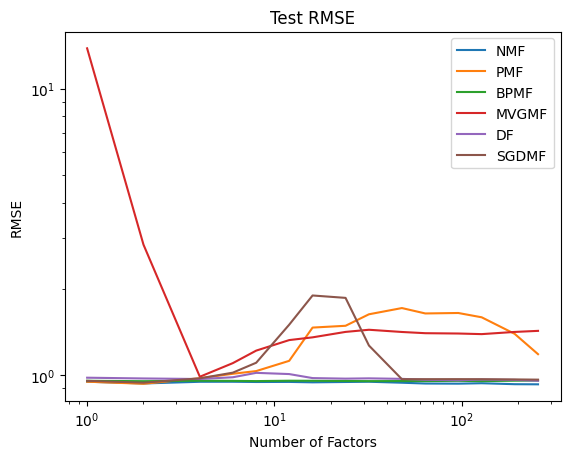

In [3]:
# Plot the test RMSE for each algorithm
plt.plot(nmf_num_factors['num_factors'], nmf_num_factors['test_RMSE'], label='NMF')
plt.plot(pmf_num_factors['num_factors'], pmf_num_factors['test_RMSE'], label='PMF')
plt.plot(bpmf_num_factors['num_factors'], bpmf_num_factors['test_RMSE'], label='BPMF')
plt.plot(mvgmf_num_factors['num_factors'], mvgmf_num_factors['test_RMSE'], label='MVGMF')
plt.plot(df_num_factors['num_factors'], df_num_factors['test_RMSE'], label='DF')
plt.plot(sgdmf_num_factors['num_factors'], sgdmf_num_factors['test_RMSE'], label='SGDMF')

# Set the range of y-axis to between 0 and 1.5

# Set the axes to log scale
plt.xscale('log')
plt.yscale('log')

# Set the x-axis label and y-axis label
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')

# Set the title of the plot
plt.title('Test RMSE')

# Add a legend
plt.legend()

# Show the plot
plt.show()

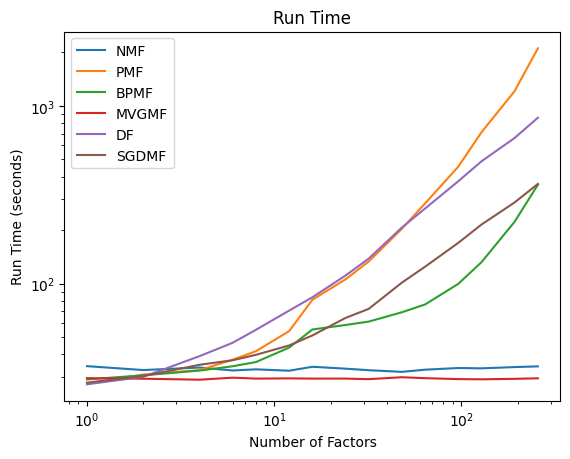

In [4]:
plt.loglog(nmf_num_factors['num_factors'], nmf_num_factors['time_taken'], label='NMF')
plt.loglog(pmf_num_factors['num_factors'], pmf_num_factors['time_taken'], label='PMF')
plt.loglog(bpmf_num_factors['num_factors'], bpmf_num_factors['time_taken'], label='BPMF')
plt.loglog(mvgmf_num_factors['num_factors'], mvgmf_num_factors['time_taken'], label='MVGMF')
plt.loglog(df_num_factors['num_factors'], df_num_factors['time_taken'], label='DF')
plt.loglog(sgdmf_num_factors['num_factors'], sgdmf_num_factors['time_taken'], label='SGDMF')

plt.xlabel('Number of Factors')
plt.ylabel('Run Time (seconds)')
plt.title('Run Time')
plt.legend()
plt.show()

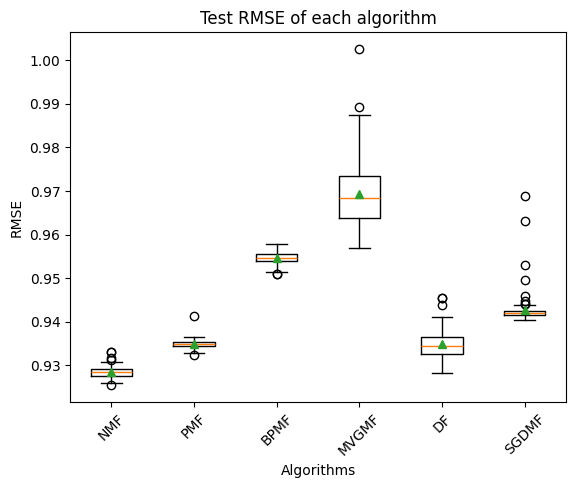

In [5]:
# Concatenate the results of all algorithms
results = pd.concat([nmf_results, pmf_results, bpmf_results, mvgmf_results, df_results, sgdmf_results])

# Plot the mean test RMSE
algorithm_names = ['NMF', 'PMF', 'BPMF', 'MVGMF', 'DF', 'SGDMF']
plt.boxplot([nmf_results['Test RMSE'], pmf_results['Test RMSE'], bpmf_results['Test RMSE'], mvgmf_results['Test RMSE'], df_results['Test RMSE'], sgdmf_results['Test RMSE']], showmeans=True)
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('Test RMSE of each algorithm')
plt.xticks(range(1, len(algorithm_names) + 1), algorithm_names, rotation=45)
plt.show()

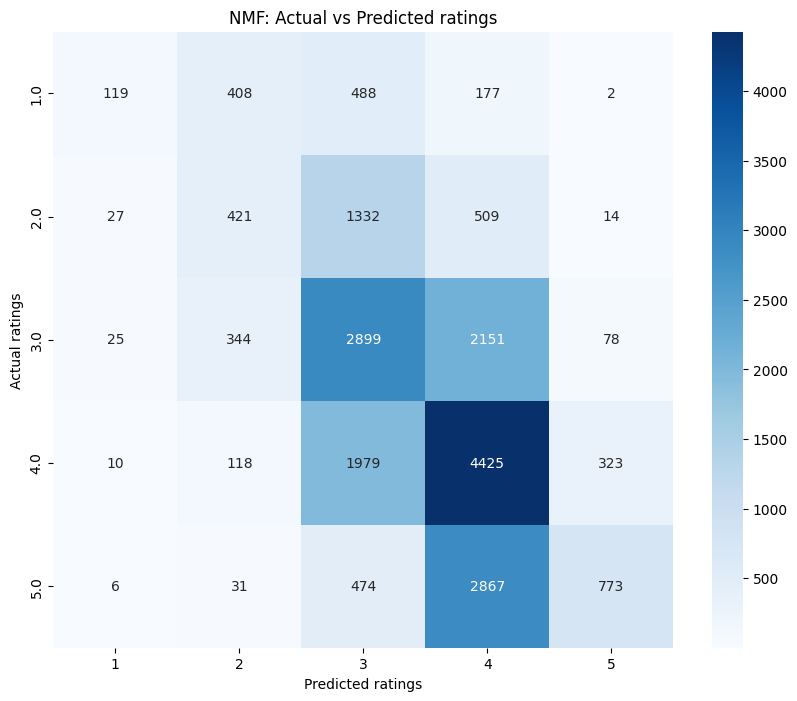

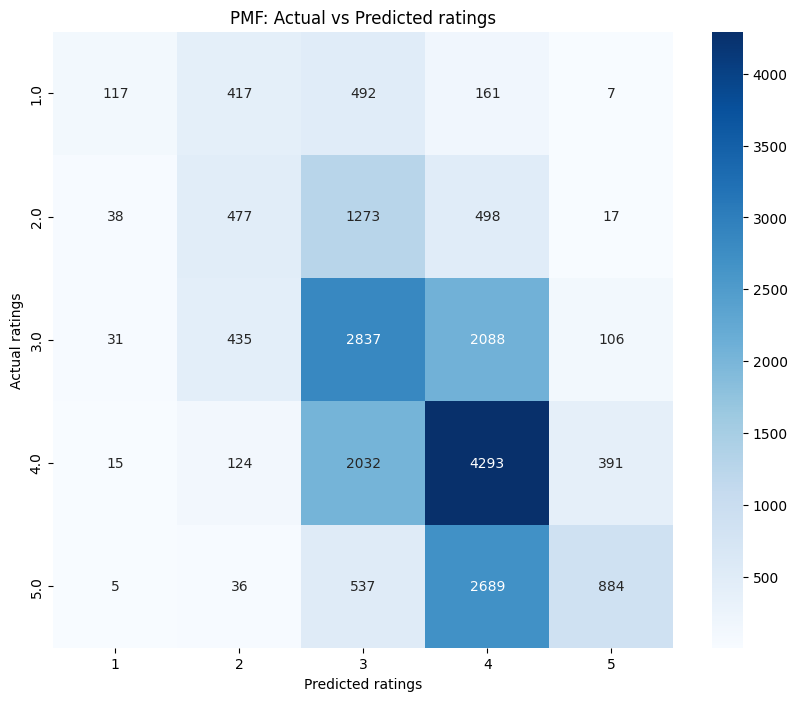

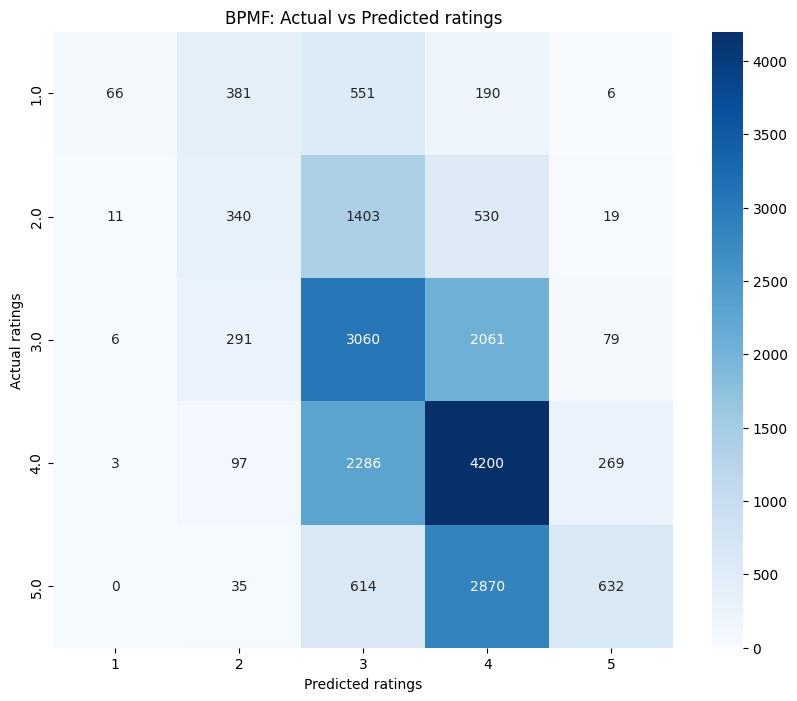

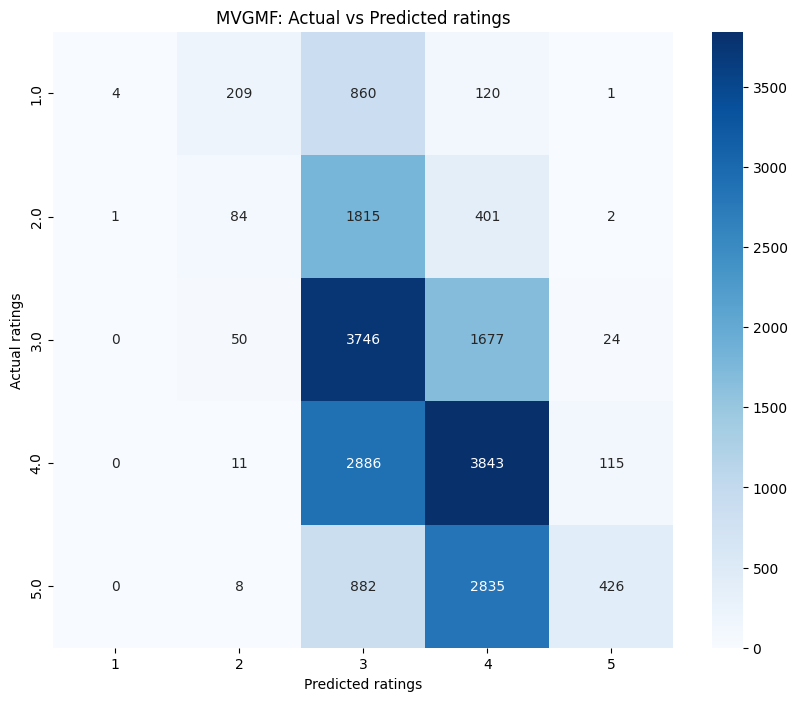

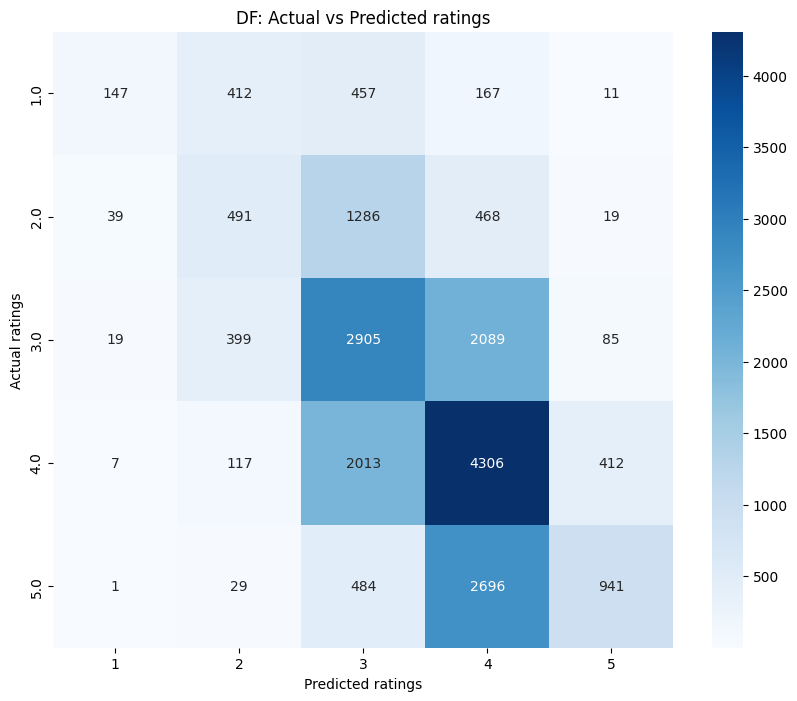

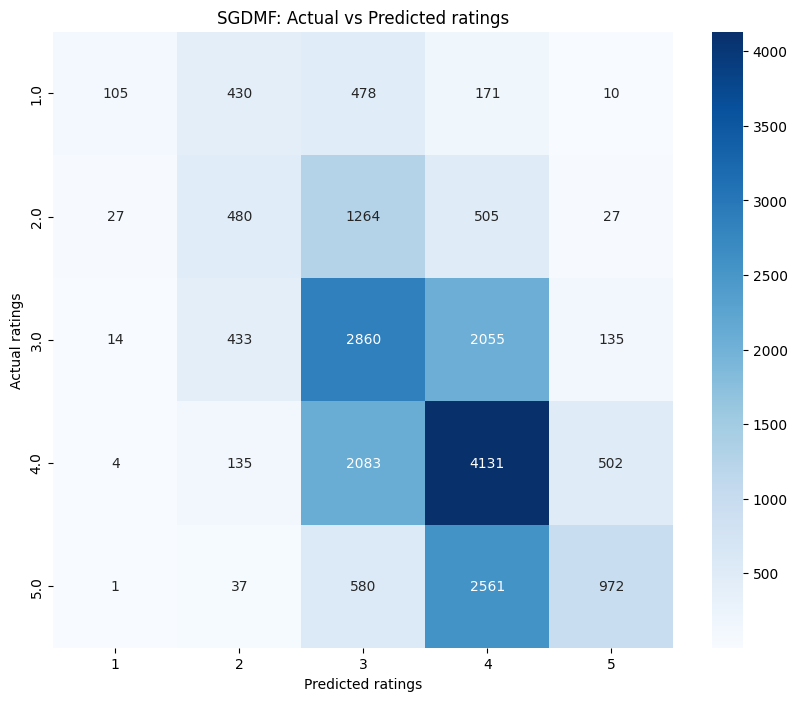

In [6]:
# Plot the heatmap for NMF
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(nmf_predictions['Actual'], nmf_predictions['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('NMF: Actual vs Predicted ratings')
plt.show()

# Plot the heatmap for PMF
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(pmf_predictions['Actual'], pmf_predictions['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('PMF: Actual vs Predicted ratings')
plt.show()

# Plot the heatmap for BPMF
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(bpmf_predictions['Actual'], bpmf_predictions['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('BPMF: Actual vs Predicted ratings')
plt.show()

# Plot the heatmap for MVGMF
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(mvgmf_predictions['Actual'], mvgmf_predictions['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('MVGMF: Actual vs Predicted ratings')
plt.show()

# Plot the heatmap for DF
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(df_predictions['Actual'], df_predictions['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('DF: Actual vs Predicted ratings')
plt.show()

# Plot the heatmap for SGDMF
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(sgdmf_predictions['Actual'], sgdmf_predictions['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted ratings')
plt.ylabel('Actual ratings')
plt.title('SGDMF: Actual vs Predicted ratings')
plt.show()